In [1]:
import numpy as np
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, Input, Dropout
from keras.optimizers import Adam, RMSprop
from sklearn.metrics import f1_score
from keras.regularizers import l2
np.random.seed(7)

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
MAX_SEQUENCE_LENGTH = 15
MAX_NB_WORDS = 10000
EMBEDDING_DIM = 300

In [3]:
data = pd.read_csv("bitcoin_data.csv")

In [4]:
data.head()

,Timestamp,Username,Label,Tweet,URL
0,"March 14, 2018 at 09:47PM",@RizkyF_404,spam,RT @kickcity_io: Token Kart added KickCity to ...,http://twitter.com/RizkyF_404/status/973903509...
1,"March 14, 2018 at 09:47PM",@exchangebutler,spam,RT @Denaro_io: Our support team is here to hel...,http://twitter.com/exchangebutler/status/97390...
2,"March 14, 2018 at 09:47PM",@Bilalbinsaqib,pos,$eth trendline broke\nnext support @600 and th...,http://twitter.com/Bilalbinsaqib/status/973903...
3,"March 14, 2018 at 09:47PM",@ahsen_soydan,spam,RT @ahsen_soydanvip: 💎 High Quality Partner ✔️...,http://twitter.com/ahsen_soydan/status/9739035...
4,"March 14, 2018 at 09:47PM",@mourneopened,hype,RT @izx_io: IZETEX is on the Battle of the Cry...,http://twitter.com/mourneopened/status/9739035...


In [5]:
data = pd.DataFrame.dropna(data)
data = pd.DataFrame.drop_duplicates(data)

In [6]:
data = data[data.Label != 'neutral']

## Multi-class classification system with 5 classes

In [7]:
print(len(data.Label.unique()))
print(len(data))

5
1338


Label
doom     62
hype    177
neg      91
pos     211
spam    797
dtype: int64


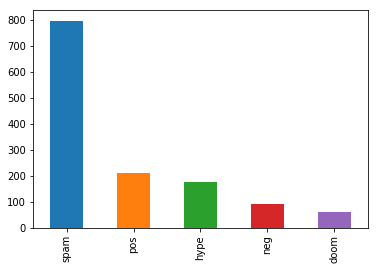

In [8]:
print(data.groupby('Label').size())
%matplotlib inline
import matplotlib as plt
data['Label'].value_counts().plot(kind="bar")

In [9]:
texts = data["Tweet"].values
labels = data["Label"].values

## Cleaning tweets

In [10]:
# stemming + stopword_removal

import re
from nltk.corpus import stopwords

text = []
for i in range(0, len(texts)):
    tweet = re.sub('[^a-zA-Z\s+]','', texts[i])
    tweet = re.sub(r'http\S+', '', texts[i]).lower().split()
    tweet = [word for word in tweet if not word in set(stopwords.words('english'))]
    tweet = ' '.join(tweet)
    text.append(tweet)
    
text = np.asarray(text)


In [11]:
# tokenizing and sequencing

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(text)
sequences = tokenizer.texts_to_sequences(text)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 6241 unique tokens.


In [12]:
df = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [13]:
target_names = data.Label.unique() # list of label ids
target_dict = {n:i for i, n in enumerate(target_names)} # list of label names
labels = data.Label.map(target_dict)
labels = to_categorical(np.asarray(labels))

In [14]:
target_dict

{'doom': 4, 'hype': 2, 'neg': 3, 'pos': 1, 'spam': 0}

In [15]:
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (1338, 5)
Shape of label tensor: (1338, 5)


In [16]:
indices = np.arange(df.shape[0])
np.random.shuffle(indices)
data = df[indices]
labels = labels[indices]

In [17]:
X = data
y = labels

In [18]:
# split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=0)

## Pre-training on Glove embeddings

In [19]:
# embedding matrx
embeddings_index = {}
f = open('glove.6B.300d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

# embedding matrix
count = 0
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, index in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[index] = embedding_vector
    else:
        count += 1
print(count) 


# embedding layer
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True) 

Found 400000 word vectors.
2238


In [20]:
# build model
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(128, recurrent_dropout=0.3)))
model.add(Dropout(0.3))
model.add(Dense(len(target_names), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.003), metrics=['acc'])

In [21]:
model.fit(X_train, y_train,
          batch_size=32,
          epochs=4, validation_data=(X_test, y_test))

Train on 1070 samples, validate on 268 samples
Epoch 1/4
1070/1070 [==============================] - 6s 5ms/step - loss: 1.1216 - acc: 0.5794 - val_loss: 1.0264 - val_acc: 0.6194
Epoch 2/4
1070/1070 [==============================] - 4s 3ms/step - loss: 0.7677 - acc: 0.7187 - val_loss: 1.0710 - val_acc: 0.6269
Epoch 3/4
1070/1070 [==============================] - 4s 4ms/step - loss: 0.4798 - acc: 0.8346 - val_loss: 1.1657 - val_acc: 0.6194
Epoch 4/4
1070/1070 [==============================] - 4s 3ms/step - loss: 0.2600 - acc: 0.9178 - val_loss: 1.2893 - val_acc: 0.6567


In [22]:
y_pred = model.predict(X_test)
y_test_class = np.argmax(y_test, axis=1)
y_pred_class = np.argmax(y_pred, axis=1)

from sklearn.metrics import classification_report
print(classification_report(y_test_class, y_pred_class, digits=3))

             precision    recall  f1-score   support

          0      0.787     0.906     0.842       159
          1      0.419     0.289     0.342        45
          2      0.400     0.400     0.400        30
          3      0.238     0.312     0.270        16
          4      0.667     0.111     0.190        18

avg / total      0.641     0.657     0.631       268



In [23]:
print({'doom': 4, 'hype': 2, 'neg': 3, 'pos': 1, 'spam': 0})

{'doom': 4, 'hype': 2, 'neg': 3, 'pos': 1, 'spam': 0}
